
# Two-Stage Insurance Claim Modeling Using DataRobot

## **Overview**

This notebook demonstrates an end-to-end **two-stage modeling workflow** for insurance claims using DataRobot, designed to closely mirror real-world insurance decisioning systems.

The modeling problem is intentionally split into two sequential stages:

- **Stage 1 – Fraud Detection (Classification):**  
  Predict whether an incoming insurance claim is likely to be fraudulent.

- **Stage 2 – Claim Severity Estimation (Regression):**  
  Estimate the total claim amount only for claims that are predicted as **non-fraudulent** in Stage 1.

---

### **Why Two-Stage Modeling?**

This use case is designed for scenarios where the business problem involves **two distinct targets**:

- A **classification target** (e.g., fraud detection)
- A **regression target** (e.g., claim severity estimation)

Such situations are common in insurance and financial services, where:
- Fraud screening must occur before claim settlement
- Severity estimation is meaningful only for non-fraudulent claims

By separating these tasks into two stages, we:
- Align with real-world operational workflows
- Reduce data leakage between models
- Enable better interpretability and governance

---

## **Objectives**

The key objectives of this notebook are to:

- Demonstrate how to implement **multi-stage modeling** in DataRobot  
- Avoid data leakage when chaining model outputs across stages  
- Apply **threshold optimization** for business-driven decision making  
- Evaluate models using **production-style, end-to-end holdout testing**  
- Validate deployed models using **DataRobot batch prediction APIs**

---

## **What This Notebook Covers**

This notebook walks through the complete lifecycle of the two-stage solution:

1. Loading and preparing insurance claim data  
2. Stratified splitting of data into training and external holdout sets  
3. Training a Stage-1 fraud classification model with cross-validation  
4. Selecting an optimal fraud threshold based on model performance  
5. Extracting cross-validated fraud probabilities to avoid leakage  
6. Training a Stage-2 regression model on non-fraud claims only  
7. Performing end-to-end evaluation on an unseen holdout dataset  
8. Testing deployed models using DataRobot’s deployment prediction workflow  

---

## **Key Design Principles**

- **Separation of concerns:** Fraud detection and severity estimation are handled by independent models  
- **No data leakage:** Stage-2 models use only out-of-sample predictions from Stage-1  
- **Deployment realism:** External predictions are used to simulate real production inference  
- **Business alignment:** Model thresholds and evaluation reflect operational trade-offs  

---

## **Stage 1: Fraud Detection (Classification)**

### Steps:
1. **Prepare Stage 1 Data**
   - Load raw dataset
   - Split into training and holdout sets
   - Save `stage_1_data.csv` for modeling

2. **Modeling in DataRobot UI**
   - Upload `stage_1_data.csv`
   - Set target: in this case it is `fraud_reported`
   - Run AutoML for classification
   - Select best model based on metrics:
     - AUC, LogLoss, F1 Score
   - Optimize threshold for business needs
   - Deploy the model and note Project ID

---

## **Stage 2: Claim Severity Estimation (Regression)**

Once Stage 1 model is deployed:

1. **Fetch CV Predictions**
   - Use DataRobot API to get cross-validation predictions for fraud probability
   - Merge predictions with original training data

2. **Prepare Stage 2 Dataset**
   - Add fraud probability column in this case it is (`fraud probability`)
   - Drop `row_id` and `fraud_reported`
   - Save as `stage_2_data.csv`

3. **Modeling in DataRobot UI**
   - Upload `stage_2_data.csv` in **Old Classic UI**
   - Set target: `total_claim_amount`
   - **Enable External Prediction** in Advanced Options
     - Select `fraud probability` as external predictor
   - Run AutoML for regression
   - Evaluate metrics: RMSE, MAE, R²
   - Deploy the model and note Project ID

---

## **Workflow Summary**


# Importing Libraries:
* Importing all the necessary libraries
* This notebook uses several Python libraries for data manipulation, visualization, modeling, and integration with DataRobot. Below is a breakdown of each:

In [1]:

# ===============================
# Import Required Libraries
# ===============================

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For file handling and temporary storage
import os
import tempfile

# For visualization
import matplotlib.pyplot as plt

# For splitting data and evaluating metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,        # Classification metric
    classification_report,    # Detailed classification performance
    mean_squared_error,       # Regression metric
    mean_absolute_error       # Regression metric
)

# For connecting with DataRobot API
import datarobot as dr

# Initialize DataRobot client
dr.Client()

RESTClientObject(https://app.datarobot.com/api/v2, 3.11.0rc1)

# Helper Functions: Data Loading, Model Selection, and CV Predictions

This section provides three reusable helpers that streamline the two-stage workflow by standardizing how we **load data**, **choose a model**, and **extract out-of-sample predictions** from DataRobot.

In [2]:
def get_training_data(proj, fallback_path=None):
    """
    Load the training dataset associated with a DataRobot project, with an optional CSV fallback.

    This function first attempts to fetch the dataset directly from the DataRobot backend
    via the project object (if it exposes a `get_dataset()` method). If that fails (e.g.,
    because the project doesn't expose a dataset object in the current context), it will
    try to load a local CSV from `fallback_path` (if provided and exists
    """
    df = None
    try:
        dataset_func = getattr(proj, "get_dataset", None)
        if callable(dataset_func):
            dataset_obj = dataset_func()
            if dataset_obj is not None:
                df = dataset_obj.get_as_dataframe()
                print(f"> Loaded dataset from DataRobot backend. Shape: {df.shape}")
                return df
    except Exception as e:
        print(f"Could not fetch dataset from DataRobot: {e}")

    if fallback_path and os.path.exists(fallback_path):
        df = pd.read_csv(fallback_path)
        print(f"> Loaded fallback dataset: {fallback_path} | Shape: {df.shape}")
        return df

    raise RuntimeError(" Could not load training data.")

# ************************************************************************************************
def get_recommended_model(proj):
    """
    Fetch the model recommended for deployment from a DataRobot project.
    Uses DataRobot's `ModelRecommendation` API to retrieve the model that is
    recommended for deployment based on platform evaluation
    """
    try:
        recom_model = dr.ModelRecommendation.get(
            proj.id,
            dr.enums.RECOMMENDED_MODEL_TYPE.RECOMMENDED_FOR_DEPLOYMENT
        ).get_model()
        print(f"> Recommended model: {recom_model.model_type} | ID: {recom_model.id}")
        return recom_model
    except Exception as e:
        raise RuntimeError("xxxx No recommended model found") from e


# ************************************************************************************************


def get_cv_predictions(model):
    """
    Request and retrieve out-of-sample (cross-validation) training predictions for a model.

    This function requests training predictions for the entire training data subset and
    returns only out-of-sample folds (i.e., excludes Holdout). If the predictions already
    exist on the backend, it will reuse them rather than recomputing
    """
    try:
        job = model.request_training_predictions(
            data_subset=dr.enums.DATA_SUBSET.ALL
        )
        job.wait_for_completion()
        preds = job.get_result_when_complete()
    except dr.errors.ClientError as e:
        if e.status_code == 422:
            preds = [
                tp for tp in dr.TrainingPredictions.list(model.project_id)
                if tp.data_subset == dr.enums.DATA_SUBSET.ALL
                and tp.model_id == model.id
            ][0]
        else:
            raise e

    df_preds = preds.get_all_as_dataframe()

    # KEEP ONLY CV (out-of-sample), DROP Holdout
    df_cv = df_preds[df_preds["partition_id"] != "Holdout"].copy()
    print(df_cv.shape)

    print(f"> Loaded CV predictions (no holdout). Shape: {df_cv.shape}")
    return df_cv


## **Configuration Settings**

This section defines all the key configuration parameters for the two-stage modeling workflow.  
Update these values as needed before running the notebook.

---

### **Target Variables**
- `Stage_1_Target` → Target for **Stage 1 Classification Model** (Fraud Detection)  
- `Stage_2_Target` → Target for **Stage 2 Regression Model** (Claim Severity Estimation)  

---

### **Prediction Column Names**
- `Predicted_Probability` → Column name for fraud probability predicted by Stage 1 model  
- `Predicted_Amount` → Column name for claim amount predicted by Stage 2 model  

---

### **Modeling Parameters**
- `RANDOM_STATE` → Random seed for reproducibility  

---

### **Data Paths**
- `DATA_DIR` → Base directory for all data files  
- `RAW_FILE` → Path to raw insurance claims dataset  
- `HOLDOUT_FILE` → Path to holdout dataset for final evaluation  
- `STAGE1_FILE` → Path to Stage 1 training data  
- `STAGE2_FILE` → Path to Stage 2 training data  

---

### **Results Paths**
- `stage_1_results` → Path to save Stage 1 prediction results  
- `stage_2_results` → Path to save Stage 2 prediction results  

---

**Note:**  
Ensure that the directory structure exists before saving files.  
Modify paths if running in a different environment.


In [3]:
# target variable for stage 1 and stage 2 model:-
Stage_1_Target = "fraud_reported"  # target for stage 1 model (classification model)
Stage_2_Target = "total_claim_amount"  # target for stage 2 model ( rgeression)

#-- Prediction column name
Predicted_Probability = "fraud probability"  # give a name to the probability column which the classification model creates while doing the prediction
Predicted_Amount ="predicted_total_claim_amount"  # give a name to the predicted column which the Regression model creates while doing the prediction

# Modeling parameters
RANDOM_STATE = 42

# Data paths
DATA_DIR = "//home/notebooks/storage"

# File paths
RAW_FILE = os.path.join(DATA_DIR, "insurance_claims.csv")
HOLDOUT_FILE = os.path.join(DATA_DIR, "holdout.csv")
STAGE1_FILE = os.path.join(DATA_DIR, "stage_1_data.csv")
STAGE2_FILE = os.path.join(DATA_DIR, "stage_2_data.csv")

# Savings Results path for prediction of new data:
stage_1_results = os.path.join(DATA_DIR,"Results/stage_1_results.csv")
stage_2_results = os.path.join(DATA_DIR,"Results/stage_2_results.csv")

# Data Preparation for Two Stage Modelling:


## **Stage 1: Data Preparation**

In this step, we prepare the dataset for **Stage 1 modeling (Fraud Detection)**:

---

### **Steps Performed**
1. **Load Raw Data**
   - Read the insurance claims dataset from `RAW_FILE`.
   - Display the shape of the dataset and the distribution of the target variable in this case it is -(`fraud_reported`).

2. **Split Data into Training and Holdout Sets**
   - Use `train_test_split` with:
     - `test_size=0.20` → 20% of data reserved for holdout.
     - `stratify=df[Stage_1_Target]` → Maintain fraud ratio in both sets.
     - `random_state=42` → Ensure reproducibility.
   - Print shapes of training and holdout sets.

3. **Save Prepared Data**
   - Save **Stage 1 training data** to: `stage_1_data.csv` (`STAGE1_FILE`).
   - Save **Holdout data** to: `holdout.csv` (`HOLDOUT_FILE`).
   - These files will be used for:
     - Stage 1 modeling in DataRobot UI.
     - End-to-end evaluation after deployment.

---

### **Why Holdout Data?**
- The holdout set simulates **unseen production data**.
- It ensures that model performance is evaluated on data not used during training or cross-validation.

---

**Output Files:**
- `stage_1_data.csv` → Training data for Stage 1 model.
- `holdout.csv` → Holdout data for final evaluation.


In [4]:
# reading initial raw data

df = pd.read_csv(RAW_FILE) # -reading the data

print(df.shape)
print(df[Stage_1_Target].value_counts()) # target distribution of bianry classification

(1000, 38)
0    753
1    247
Name: fraud_reported, dtype: int64


In [5]:
df.head()

,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,17-10-2014,OH,250/500,1000,1406.91,0,466132,MALE,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,MALE,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,MALE,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


In [5]:
# splitting the data into train and holdout in equal ratio of classes 
train_df, holdout_df = train_test_split(
    df,
    test_size=0.20,                 # 20% holdout
    stratify=df[Stage_1_Target],   # keep fraud ratio
    random_state=42)

print(train_df.shape ,holdout_df.shape)

(800, 38) (200, 38)


In [6]:
## checking the distribution of target variable in training and holdout:
print("TRAIN distribution")
print(train_df[Stage_1_Target].value_counts(normalize=True))

print("\nHOLDOUT distribution")
print(holdout_df[Stage_1_Target].value_counts(normalize=True))


TRAIN distribution
0    0.7525
1    0.2475
Name: fraud_reported, dtype: float64

HOLDOUT distribution
0    0.755
1    0.245
Name: fraud_reported, dtype: float64


In [7]:
# -------------          saving dataframe for Stage 1 Model and Hold out data 

train_df.to_csv(STAGE1_FILE, index=False) # saving stage 1 training data:
holdout_df.to_csv(HOLDOUT_FILE, index=False) # saving holdout data

# Pulling training data :


## **Stage 1: Fetching Model Outputs and Preparing Data for Stage 2**

This section connects to the deployed Stage 1 project in DataRobot, retrieves the recommended model, and extracts **cross-validation predictions** to prepare data for Stage 2 modeling.

---

### **Steps Performed**

1. **Set Project ID**
   - Use `STAGE1_PROJECT_ID` to identify the Stage 1 project in DataRobot.

2. **Load Project**
   - Fetch the DataRobot project object using `dr.Project.get()`.

3. **Load Training Data**
   - Retrieve training data from the project using `get_training_data()`.
   - If backend retrieval fails, fallback to local file: `stage_1_data.csv`.

4. **Get Recommended Model**
   - Use `get_recommended_model()` to fetch the model recommended for deployment.

5. **Fetch Cross-Validation Predictions**
   - Use `get_cv_predictions()` to request or reuse training predictions.
   - Exclude Holdout partition to prevent leakage.
   - Validate that the fraud probability column (`class_1`) exists.

6. **Rename Prediction Column**
   - Rename `class_1` to `fraud probability` (defined in `Predicted_Probability`).

7. **Merge Predictions with Training Data**
   - Merge CV predictions with original training data on `row_id`.
   - This merged dataset will be used for Stage 2 regression modeling.

---

### **Output**
- A merged DataFrame containing:
  - Original training features
  - Fraud probability from Stage 1 model
- Shape of merged dataset is printed for verification.

---

**Next Step:**  
Drop unnecessary columns (`row_id`, `fraud_reported`) and save the dataset as `stage_2_data.csv` for Stage 2 modeling.
``


In [8]:
# --Project & Deployment IDs
STAGE1_PROJECT_ID = "6953c589de9785d000e0ca62"  # Get the project Id once you create project for stage 1 through UI
#STAGE2_PROJECT_ID = "6954fc4c2b90edb117a6339d"  # Get the project Id Once you create project for stage 2 through UI

PROJECT_ID = STAGE1_PROJECT_ID

# ===============================
# LOAD PROJECT
# ===============================
project = dr.Project.get(PROJECT_ID)


# ===============================
# LOAD TRAINING DATA
# ===============================
train_df = get_training_data(project , fallback_path=STAGE1_FILE)
if "row_id" not in train_df.columns:
    train_df = train_df.reset_index(drop=True)
    train_df["row_id"] = train_df.index.astype(str)
    print("✔ row_id column created in training data")

# ===============================
# GET STAGE-1 MODEL
# ===============================
stage1_model = get_recommended_model(project)

# ===============================
# GET CV PREDICTIONS
# ===============================
cv_preds = get_cv_predictions(stage1_model)

# Expect column class_1 = P(fraud = 1)
if "class_1" not in cv_preds.columns:
    raise ValueError("xxxxx class_1 fraud probability column not found")

cv_preds = cv_preds[["row_id", "class_1"]].rename(
    columns={"class_1": Predicted_Probability}
)

# ===============================
# MERGE WITH TRAINING DATA
# ===============================

train_df["row_id"] = train_df["row_id"].astype(str)
cv_preds["row_id"] = cv_preds["row_id"].astype(str)
merged_df = train_df.merge(
    cv_preds,
    on="row_id",
    how="inner"
)

print(f"> Merged training + CV preds. Shape: {merged_df.shape}")


> Loaded dataset from DataRobot backend. Shape: (800, 38)
✔ row_id column created in training data
> Recommended model: RandomForest Classifier (Gini) | ID: 6953c7cf665fa31e1ac9e4f1
(640, 5)
> Loaded CV predictions (no holdout). Shape: (640, 5)
> Merged training + CV preds. Shape: (640, 40)


In [9]:
merged_df.head()

,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,row_id,fraud probability
0,441,55,29-07-2009,IN,250/500,500,1270.29,4000000,449421,MALE,...,6400,640,640,5120,Honda,Civic,2002,0,0,0.068386
1,275,45,06-12-1991,IN,500/1000,2000,1447.77,0,605756,FEMALE,...,64320,5360,10720,48240,Accura,MDX,1998,0,1,0.405179
2,421,56,15-02-1990,IN,100/300,500,1935.85,4000000,470826,MALE,...,92730,16860,8430,67440,Mercedes,E400,2004,1,2,0.321332
3,4,34,24-05-2003,OH,500/1000,500,1282.93,0,616126,FEMALE,...,66880,6080,12160,48640,Chevrolet,Silverado,1996,1,3,0.224521
4,257,44,12-07-2006,OH,100/300,1000,1280.88,0,433981,MALE,...,46980,0,5220,41760,Accura,TL,2002,0,4,0.067509


In [10]:
print("Train rows:", train_df.shape[0])
print("CV preds rows:", cv_preds.shape[0])
print("Merged rows:", merged_df.shape[0])

Train rows: 800
CV preds rows: 640
Merged rows: 640



# **Stage 2: Regression Data Preparation**

In this step, we prepare the dataset for **Stage 2 modeling (Claim Severity Estimation)** using outputs from the Stage 1 model.

---

### **Steps Performed**

1. **Filter Non-Fraudulent Claims**
   - Select rows where `fraud_reported == 0` (i.e., predicted/actual non-fraud cases).
   - This ensures the regression model is trained only on claims that would be processed for settlement.

   ```python
   stage2_df = merged_df[merged_df[Stage_1_Target] == 0].copy()


In [11]:
## filteriung non fraudlent cases for stage 2 Training- This is stage 2 Training data:

stage2_df = merged_df[
    merged_df[Stage_1_Target] == 0
].copy()

# ---Drop 'row_id' and Stage 1 target column 'fraud_reported' which should not be passed in stage 2 modelling-
columns_to_drop = ["row_id", Stage_1_Target]

stage2_df = stage2_df.drop(columns=columns_to_drop, errors="ignore")

print(stage2_df.shape)

(481, 38)
(481, 38)


In [13]:
stage2_df[Stage_2_Target].describe()

count       481.000000
mean      50767.817048
std       27542.846001
min        1920.000000
25%       36700.000000
50%       56600.000000
75%       69630.000000
max      114920.000000
Name: total_claim_amount, dtype: float64

In [12]:
# saving stage 2 Training data for training the model thorugh UI:
stage2_df.to_csv(STAGE2_FILE, index=False) # saving stage 2 training data:


# **End-to-End Scoring Flow for Holdout / New Data (Deployments)**

This section documents a complete, production-style scoring workflow for **holdout** or **new/unseen data** using the **deployed Stage 1 (fraud classification)** and **Stage 2 (claim severity regression)** models in DataRobot.  
It also includes **optional evaluation** steps (only applicable when you have actual labels/targets).

---

## **1) Read & Prepare Holdout / New Data**

- Load the external holdout dataset from `HOLDOUT_FILE`.
- Create a stable `row_id` column to preserve row alignment across scoring outputs and merges.

**What the code does:**
- Reads `holdout_df`
- Prints shape for a quick sanity check
- Resets the index and creates `row_id` as a string

---

## **2) Stage 1 Scoring — Fraud Detection (Deployment)**

### **2.1 Prepare Features**
- Copy holdout data to an interim DataFrame for scoring.
- **Remove the Stage 1 target** (`fraud_reported`) before scoring. Deployments expect only **feature columns**.

### **2.2 Run Batch Prediction**
- Use `dr.BatchPredictionJob.score` with **local file intake/output**:
  - Writes features to `stage1_input.csv` in a temp directory
  - Reads predictions from `stage1_output.csv` after the job completes

### **2.3 Attach Deployment Outputs**
- Merge deployment outputs back onto the original `holdout_df` (row-aligned).
- Store:
  - `fraud_reported_1_PREDICTION` → **`fraud probability`** (probability of the positive class)
  - `fraud_reported_PREDICTION` → **`fraud_predicted`** (final decision after threshold)

### **2.4 Log Threshold Metadata**
- Print:
  - **`THRESHOLD`** (the decision threshold used by the deployment)
  - **`POSITIVE_CLASS`** (label treated as positive during scoring)

### **2.5 Summary**
- Print count of total records scored
- Print number of **predicted fraud cases**

---

## **3) (Optional) Evaluate Stage 1 — Only If Actuals Exist**

> Skip this for **true new data** where you do not have the actual label `fraud_reported`.

- Build:
  - `y_true_stage1` from `holdout_scored[fraud_reported]`
  - `y_pred_stage1` from `holdout_scored[fraud_predicted]`
- Print:
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1, etc.)

---

## **4) Route Non-Fraud Records to Stage 2**
- Filter **non-fraud predictions**: `fraud_predicted == 0`
- Print the number of rows passed forward to Stage 2
- Persist full Stage 1 results for auditability:
  - Save `holdout_scored` to `stage_1_results` (includes probabilities, decisions, and metadata)

---

## **5) Stage 2 Scoring — Claim Severity Regression (Deployment)**

### **5.1 Build Stage 2 Input**
- From `holdout_scored`, select only records with `fraud_predicted == 0`
- **Remove Stage 2 target** (`total_claim_amount`) if present—deployments expect features only

### **5.2 Run Batch Prediction**
- Use `dr.BatchPredictionJob.score` for Stage 2 deployment:
  - Writes features to `stage2_input.csv`
  - Reads predictions from `stage2_output.csv`

### **5.3 Attach Predictions**
- Expect the regression output column:
  - `total_claim_amount_PREDICTION`
- Attach to the filtered input as:
  - **`predicted_total_claim_amount`** (stored in `Predicted_Amount`)
- Create `final_stage2_results` containing the non-fraud rows and their predicted claim amounts
- Print completion message

### **5.4 Persist Stage 2 Results**
- Save `final_stage2_results` to `stage_2_results` for downstream reporting and audit

---

## **6) (Optional) Evaluate Stage 2 — Only If Actuals Exist**

> Skip for **new data** where actual `total_claim_amount` is not known.

- Restrict evaluation to **non-fraud rows** (`fraud_predicted == 0`)
- Compute:
  - **RMSE** (Root Mean Squared Error)
  - **MAE** (Mean Absolute Error)
- Print the metrics

### **6.1 Visual Check (Optional)**
- Sort by actual claim amount for smoother curves
- Plot **Actual vs Predicted** claim amounts to visually inspect calibration and spread
  - X-axis: Sorted claim index
  - Y-axis: Claim amount
  - Lines: Actual vs Predicted

---

## **Artifacts Saved**
- **Stage 1 Results** → `stage_1_results.csv`  
  Includes: row-wise fraud probability, final fraud decision, and deployment threshold metadata.

- **Stage 2 Results** → `stage_2_results.csv`  
  Includes: only non-fraud records with `predicted_total_claim_amount`.

---

## **Important Notes & Best Practices**
- **Targets must be removed** before scoring in both stages (`fraud_reported`, `total_claim_amount`).
- Output column names are **auto-generated** by DataRobot and depend on your target:
  - Classification probability: `<target>_1_PREDICTION`
  - Classification decision: `<target>_PREDICTION`
  - Regression prediction: `<target>_PREDICTION`
- The final fraud decision (`fraud_predicted`) reflects the **deployment’s threshold** at the time of scoring—always log the `THRESHOLD` for governance.
- If **no rows** reach Stage 2 (e.g., all predicted as fraud), revisit Stage 1 **threshold** to ensure appropriate business trade-offs.
- For large datasets, consider using **cloud intake/output** (S3, Azure Blob, GCS) instead of local files in `BatchPredictionJob`.
- Keep an **immutable audit trail**: version your outputs and include timestamps in file names when moving to production.

---

## **Flow Recap**

1. **Load holdout/new data** → create `row_id`  
2. **Score Stage 1** (drop `fraud_reported`) → get probabilities and thresholded decisions  
3. **Optional evaluation** (if actuals exist) → confusion matrix & classification report  
4. **Filter non-fraud** → save Stage 1 results  
5. **Score Stage 2** (drop `total_claim_amount`) → attach predicted claim amount  
6. **Optional evaluation** (if actuals exist) → RMSE, MAE + visualization  
7. **Save Stage 2 results** for reporting/audit

---


In [14]:
#-- Reading external holdout data:
holdout_df = pd.read_csv(HOLDOUT_FILE)

print("Holdout data shape is -:", holdout_df.shape)

# -- creating row_id:
holdout_df = holdout_df.reset_index(drop=True)
holdout_df["row_id"] = holdout_df.index.astype(str)
holdout_df.head()

Holdout data shape is -: (200, 38)


,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,row_id
0,285,44,21-08-1991,OH,250/500,2000,1144.30,0,609458,MALE,...,?,5500,500,500,4500,Honda,Civic,2010,0,0
1,230,37,11-04-2005,IL,500/1000,1000,1060.74,0,471585,MALE,...,?,49100,9820,4910,34370,Suburu,Impreza,1996,1,1
2,101,33,23-06-2012,OH,100/300,1000,1053.04,7000000,619540,FEMALE,...,?,54240,9040,9040,36160,Saab,93,2013,1,2
3,266,42,06-03-2003,IN,100/300,500,1093.83,4000000,468454,MALE,...,NO,53280,4440,8880,39960,Suburu,Impreza,2015,1,3
4,430,59,10-01-2004,OH,250/500,2000,1326.62,7000000,477310,MALE,...,YES,81800,16360,8180,57260,Nissan,Pathfinder,1998,0,4


In [18]:
STAGE1_DEPLOYMENT_ID = "695e23a4ae777617a6acb663"  # Once you deploy the model for stage 1 through UI and get the deployment Id
STAGE2_DEPLOYMENT_ID = "695e242e6f01c7ee06acb644"  # Once deploy stage 2 model get the deployment id

# --------------------------------------------------
# PREPARE HOLDOUT DATA FOR SCORING
# --------------------------------------------------
STAGE1_DEPLOYMENT_ID =STAGE1_DEPLOYMENT_ID

holdout_scoring_df = holdout_df.copy()

# Remove target before deployment scoring
if Stage_1_Target in holdout_scoring_df.columns:
    holdout_scoring_df_features = holdout_scoring_df.drop(columns=[Stage_1_Target])
else:
    holdout_scoring_df_features = holdout_scoring_df.copy()

# --------------------------------------------------
# RUN DEPLOYMENT-BASED BATCH PREDICTION
# --------------------------------------------------

with tempfile.TemporaryDirectory() as tmpdir:
    input_csv = os.path.join(tmpdir, "stage1_input.csv")
    output_csv = os.path.join(tmpdir, "stage1_output.csv")

    holdout_scoring_df_features.to_csv(input_csv, index=False)

    job = dr.BatchPredictionJob.score(
        deployment=STAGE1_DEPLOYMENT_ID,
        intake_settings={
            "type": "localFile",
            "file": input_csv,
        },
        output_settings={
            "type": "localFile",
            "path": output_csv,
        },
    )

    job.wait_for_completion()

    stage1_preds = pd.read_csv(output_csv)

# --------------------------------------------------
# ATTACH DEPLOYMENT OUTPUTS BACK
# --------------------------------------------------

holdout_scored = holdout_df.reset_index(drop=True).copy()
stage1_preds = stage1_preds.reset_index(drop=True)

# Probability of fraud (for analysis)
holdout_scored[Predicted_Probability] = stage1_preds[
    "fraud_reported_1_PREDICTION"
].values

#  Final fraud decision from deployment (threshold already applied)
holdout_scored["fraud_predicted"] = stage1_preds[
    "fraud_reported_PREDICTION"
].values

# --------------------------------------------------
# PRINT DEPLOYMENT THRESHOLD INFO
# --------------------------------------------------

deployment_threshold = stage1_preds["THRESHOLD"].iloc[0]
positive_class = stage1_preds["POSITIVE_CLASS"].iloc[0]

print("Stage-1 deployment threshold used:", deployment_threshold)
print("Stage-1 positive class:", positive_class)

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------

print("Stage-1 scoring completed")
print("Total records scored:", holdout_scored.shape[0])
print("Predicted fraud cases:", holdout_scored["fraud_predicted"].sum())

holdout_scored.head()

Stage-1 deployment threshold used: 0.2384
Stage-1 positive class: 1
Stage-1 scoring completed
Total records scored: 200
Predicted fraud cases: 87


,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,row_id,fraud probability,fraud_predicted
0,285,44,21-08-1991,OH,250/500,2000,1144.30,0,609458,MALE,...,500,500,4500,Honda,Civic,2010,0,0,0.154687,0
1,230,37,11-04-2005,IL,500/1000,1000,1060.74,0,471585,MALE,...,9820,4910,34370,Suburu,Impreza,1996,1,1,0.149783,0
2,101,33,23-06-2012,OH,100/300,1000,1053.04,7000000,619540,FEMALE,...,9040,9040,36160,Saab,93,2013,1,2,0.193384,0
3,266,42,06-03-2003,IN,100/300,500,1093.83,4000000,468454,MALE,...,4440,8880,39960,Suburu,Impreza,2015,1,3,0.171730,0
4,430,59,10-01-2004,OH,250/500,2000,1326.62,7000000,477310,MALE,...,16360,8180,57260,Nissan,Pathfinder,1998,0,4,0.206275,0


In [19]:
# skip this step for new data ( only if we have actuals with me)

#---- evaluate stage 1:
y_true_stage1 = holdout_scored[Stage_1_Target]
y_pred_stage1 = holdout_scored["fraud_predicted"]

print("=== Stage-1 Confusion Matrix ===")
print(confusion_matrix(y_true_stage1, y_pred_stage1))

print("\n=== Stage-1 Classification Report ===")
print(classification_report(y_true_stage1, y_pred_stage1))

=== Stage-1 Confusion Matrix ===
[[89 62]
 [24 25]]

=== Stage-1 Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.59      0.67       151
           1       0.29      0.51      0.37        49

    accuracy                           0.57       200
   macro avg       0.54      0.55      0.52       200
weighted avg       0.67      0.57      0.60       200



# Saving Stage 1 Results:


In [20]:
#--- filter predicted non fraud for stage 2:
holdout_stage2 = holdout_scored[
    holdout_scored["fraud_predicted"] == 0
].copy()

print("Rows passed to Stage-2:", holdout_stage2.shape)

# saving results

os.makedirs(os.path.dirname(stage_1_results), exist_ok=True)
holdout_scored.to_csv(stage_1_results, index=False)

Rows passed to Stage-2: (113, 41)


# Stage 2 Starts:

In [22]:
STAGE2_DEPLOYMENT_ID = STAGE2_DEPLOYMENT_ID

# --------------------------------------------------
# FILTER NON-FRAUD CLAIMS (DEPLOYMENT DECISION)
# --------------------------------------------------

stage2_input_df = holdout_scored[
    holdout_scored["fraud_predicted"] == 0
].reset_index(drop=True)

print("Records passed to Stage-2 for Regression or severity model", stage2_input_df.shape[0])

# --------------------------------------------------
# ----REMOVing STAGE-2 TARGET BEFORE SCORING
# --------------------------------------------------

if Stage_2_Target in stage2_input_df.columns:
    stage2_features_df = stage2_input_df.drop(columns=[Stage_2_Target])
else:
    stage2_features_df = stage2_input_df.copy()

# --------------------------------------------------
# RUN STAGE-2 DEPLOYMENT-BASED BATCH PREDICTION
# --------------------------------------------------

with tempfile.TemporaryDirectory() as tmpdir:
    input_csv = os.path.join(tmpdir, "stage2_input.csv")
    output_csv = os.path.join(tmpdir, "stage2_output.csv")

    stage2_features_df.to_csv(input_csv, index=False)

    job = dr.BatchPredictionJob.score(
        deployment=STAGE2_DEPLOYMENT_ID,
        intake_settings={
            "type": "localFile",
            "file": input_csv,
        },
        output_settings={
            "type": "localFile",
            "path": output_csv,
        },
    )

    job.wait_for_completion()

    stage2_preds = pd.read_csv(output_csv)

# --------------------------------------------------
# ATTACH STAGE-2 PREDICTIONS BACK
# --------------------------------------------------

stage2_input_df = stage2_input_df.reset_index(drop=True)
stage2_preds = stage2_preds.reset_index(drop=True)

pred_col = f"{Stage_2_Target}_PREDICTION"

assert pred_col in stage2_preds.columns, (
    f"Expected prediction column '{pred_col}' not found. "
    f"Available columns: {stage2_preds.columns.tolist()}"
)

stage2_input_df[Predicted_Amount] = stage2_preds[pred_col].values

final_stage2_results = stage2_input_df.copy()

print("Stage-2 scoring completed")
final_stage2_results.head()

Records passed to Stage-2 for Regression or severity model 113
Stage-2 scoring completed


,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,row_id,fraud probability,fraud_predicted,predicted_total_claim_amount
0,285,44,21-08-1991,OH,250/500,2000,1144.30,0,609458,MALE,...,500,4500,Honda,Civic,2010,0,0,0.154687,0,6694.188477
1,230,37,11-04-2005,IL,500/1000,1000,1060.74,0,471585,MALE,...,4910,34370,Suburu,Impreza,1996,1,1,0.149783,0,59787.523438
2,101,33,23-06-2012,OH,100/300,1000,1053.04,7000000,619540,FEMALE,...,9040,36160,Saab,93,2013,1,2,0.193384,0,61037.648438
3,266,42,06-03-2003,IN,100/300,500,1093.83,4000000,468454,MALE,...,8880,39960,Suburu,Impreza,2015,1,3,0.171730,0,63002.203125
4,430,59,10-01-2004,OH,250/500,2000,1326.62,7000000,477310,MALE,...,8180,57260,Nissan,Pathfinder,1998,0,4,0.206275,0,57279.753906


# Saving stage 2 predictions Results:

In [23]:
## --- saving stage 2 results---
os.makedirs(os.path.dirname(stage_2_results), exist_ok=True)
final_stage2_results.to_csv(stage_2_results, index=False)

In [24]:
# ----------evaluate stage 2 prediction:
mask = final_stage2_results["fraud_predicted"] == 0
print(mask.shape)
y_true_stage2 = final_stage2_results.loc[mask, "total_claim_amount"]
y_pred_stage2 = final_stage2_results.loc[mask, "predicted_total_claim_amount"]

rmse = mean_squared_error(y_true_stage2, y_pred_stage2, squared=False)
mae = mean_absolute_error(y_true_stage2, y_pred_stage2)


print("=== Stage-2 Regression Metrics (Holdout) ===")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")


(113,)
=== Stage-2 Regression Metrics (Holdout) ===
RMSE: 13,521.32
MAE : 10,100.36
/etc/system/kernel/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Visualization

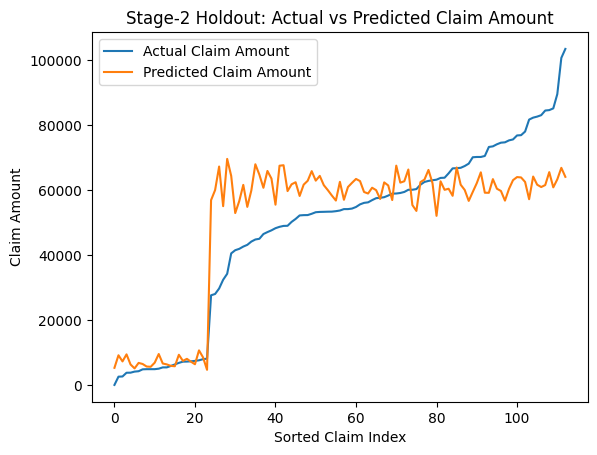

In [25]:
# Sort by actual claim amount for a smooth line
plot_df = final_stage2_results.loc[mask, [
    Stage_2_Target,
    Predicted_Amount
]].copy()

plot_df = plot_df.sort_values(Stage_2_Target).reset_index(drop=True)

plt.figure()
plt.plot(
    plot_df[Stage_2_Target].values,
    label="Actual Claim Amount"
)
plt.plot(
    plot_df[Predicted_Amount].values,
    label="Predicted Claim Amount"
)

plt.xlabel("Sorted Claim Index")
plt.ylabel("Claim Amount")
plt.title("Stage-2 Holdout: Actual vs Predicted Claim Amount")
plt.legend()
plt.show()


## End 